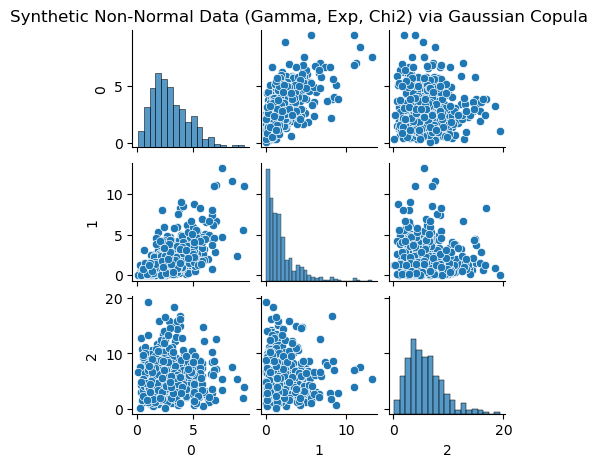

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha_gamma]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [rate_exp]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu_chi2]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sam

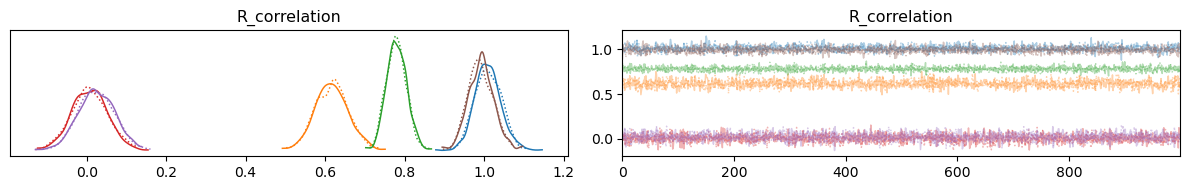

In [3]:
#Q1
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd

# ============================
# 1) Generate correlated data x (standard normal, dimension=3)
# ============================
N = 500
rho = 0.6  # correlation between first two columns
cov = [
    [1.0, rho, 0.0],
    [rho, 1.0, 0.0],
    [0.0, 0.0, 1.0]
]
x = np.random.multivariate_normal(mean=[0, 0, 0], cov=cov, size=N)

# ============================
# 2) Convert x to y with desired marginals
#    (Gamma, Exponential, ChiSquared) via PPF
# ============================
y = x.copy()
# 1st col -> Gamma(a=3, scale=1)
y[:, 0] = stats.gamma(a=3).ppf(stats.norm().cdf(x[:, 0]))

# 2nd col -> Exponential(scale=2)
y[:, 1] = stats.expon(scale=2).ppf(stats.norm().cdf(x[:, 1]))

# 3rd col -> ChiSquared(df=6)
y[:, 2] = stats.chi2(6).ppf(stats.norm().cdf(x[:, 2]))

# Quick visualization of the resulting data
sns.pairplot(pd.DataFrame(y), height=1.5)
plt.suptitle("Synthetic Non-Normal Data (Gamma, Exp, Chi2) via Gaussian Copula", y=1.02)
plt.show()

# ============================
# 3) Two-pass approach:
#    (A) Fit each marginal separately
#    (B) Fit the correlation structure (Copula)
# ============================

# --- Marginal 1: Gamma ---
with pm.Model() as marginal_gamma:
    alpha_gamma = pm.HalfNormal("alpha_gamma", sigma=10)
    obs_gamma = pm.Gamma("obs_gamma", alpha=alpha_gamma, beta=1.0, observed=y[:, 0])
    trace_gamma = pm.sample(1000, tune=1000, cores=1, progressbar=False, random_seed=42)

# --- Marginal 2: Exponential ---
with pm.Model() as marginal_expon:
    rate_exp = pm.HalfNormal("rate_exp", sigma=10)
    obs_expon = pm.Exponential("obs_expon", lam=rate_exp, observed=y[:, 1])
    trace_expon = pm.sample(1000, tune=1000, cores=1, progressbar=False, random_seed=42)

# --- Marginal 3: ChiSquared ---
with pm.Model() as marginal_chi2:
    nu_chi2 = pm.HalfNormal("nu_chi2", sigma=10)
    obs_chi2 = pm.ChiSquared("obs_chi2", nu=nu_chi2, observed=y[:, 2])
    trace_chi2 = pm.sample(1000, tune=1000, cores=1, progressbar=False, random_seed=42)

# Extract posterior means for each marginal parameter
alpha_gamma_mean = az.summary(trace_gamma, var_names=["alpha_gamma"])["mean"].values[0]
rate_exp_mean    = az.summary(trace_expon, var_names=["rate_exp"])["mean"].values[0]
nu_chi2_mean     = az.summary(trace_chi2, var_names=["nu_chi2"])["mean"].values[0]

# ============================
# 4) Transform data to pseudo-observations (standard normal)
# ============================
# Gamma marginal: shape=alpha_gamma_mean, scale=1
cdf_gamma = stats.gamma.cdf(y[:, 0], a=alpha_gamma_mean, scale=1.0)
z0 = stats.norm.ppf(cdf_gamma)

# Exponential marginal: scale = 1/rate
cdf_expon = stats.expon.cdf(y[:, 1], scale=1.0 / rate_exp_mean)
z1 = stats.norm.ppf(cdf_expon)

# ChiSquared marginal: df=nu_chi2_mean
cdf_chi2 = stats.chi2.cdf(y[:, 2], df=nu_chi2_mean)
z2 = stats.norm.ppf(cdf_chi2)

Z_transformed = np.column_stack([z0, z1, z2])

# ============================
# 5) Fit a Gaussian Copula using LKJCholeskyCov
# ============================
with pm.Model() as copula_model:
    # Correlation matrix prior: 3-dimensional, using LKJ
    L_chol, Rho, _ = pm.LKJCholeskyCov(
        "R_correlation", 
        n=3, 
        eta=2.0,
        sd_dist=pm.Exponential.dist(lam=1.0, shape=3),
        compute_corr=True
    )
    # Multivariate normal likelihood on the transformed data
    pm.MvNormal(
        "Z_likelihood",
        mu=np.zeros(3),
        chol=L_chol,
        observed=Z_transformed
    )
    trace_copula = pm.sample(1000, tune=1000, cores=1, progressbar=False, random_seed=42)

# Check the posterior of the correlation matrix
az.plot_trace(trace_copula, var_names=["R_correlation"])
plt.tight_layout()
plt.show()


# Copulas and Their Implementation in Bayesian Models

## 1. What is a Copula?

A **copula** is a mathematical function that decouples the joint distribution of multiple random variables into two components:
- Their **marginal distributions** (e.g., Gamma, Exponential, Chi-Squared, etc.)
- Their **dependence structure** (i.e., how they are correlated or dependent)

Formally, if \((X_1, X_2, \dots, X_d)\) has a joint cumulative distribution function (CDF) \(F\) and marginal CDFs \(F_1, F_2, \dots, F_d\), then there exists a copula \(C\) such that:

$$
F(x_1, x_2, \ldots, x_d) = C\Bigl( F_1(x_1), F_2(x_2), \ldots, F_d(x_d) \Bigr).
$$

This means that if you know the individual distributions \(F_1, F_2, \dots, F_d\) and the copula \(C\) capturing their dependence, you can reconstruct the entire joint distribution. A common example is the **Gaussian Copula**, where the dependence is modeled using a multivariate normal distribution while allowing each marginal to be any suitable distribution.

---

## 2. How the Two Versions of Code Implement a Copula

### (A) Two-Pass Approach

1. **Marginal Estimation**  
   Each variable is modeled separately using an appropriate distribution:
   - For example, assume:
     - \(Y_1 \sim \text{Gamma}(\alpha, \beta)\)
     - \(Y_2 \sim \text{Exponential}(\lambda)\)
     - \(Y_3 \sim \chi^2(\nu)\)
   - In each PyMC model, priors are placed on the parameters (e.g., a HalfNormal prior), and posterior sampling (via MCMC) is used to estimate the parameters.

2. **Data Transformation**  
   For each observed data point \(y_i\) in a given variable:
   - Compute its CDF value:
     
     $$
     u_i = F_{\theta}(y_i)
     $$
     
     where \(F_{\theta}\) is the CDF with the estimated parameters.
   - Transform the uniform variable \(u_i\) to a standard normal quantile:
     
     $$
     z_i = \Phi^{-1}(u_i)
     $$
     
     where \(\Phi^{-1}\) is the inverse standard normal CDF.

3. **Copula (Dependence) Estimation**  
   A new PyMC model is set up where the transformed pseudo-observations \(\mathbf{z} = (z_1, z_2, \dots, z_d)\) are assumed to come from a multivariate normal distribution with zero mean and a correlation matrix \(\Sigma\).  
   - A prior (e.g., using `LKJCholeskyCov`) is placed on \(\Sigma\), and sampling recovers the posterior of the dependence structure among the variables.

**Advantages:**
- Simplicity and modularity: you verify the marginal fits before addressing the dependence.
- Easier to implement using built-in distributions and transformation functions.

**Disadvantages:**
- Marginals and correlation are estimated in two separate stages rather than jointly.

---

### (B) Single-Pass (All-in-One) Approach

1. **Joint Modeling**  
   In a single PyMC model, you simultaneously define:
   - Priors for the parameters of each marginal distribution.
   - A prior for the dependence structure (e.g., a correlation matrix).
2. **Custom Likelihood**  
   A custom likelihood (or a `Potential`) is written that combines:
   - The likelihood of each observation under its marginal distribution.
   - The log-density of the chosen copula (e.g., Gaussian Copula) which encodes the dependence among the variables.

**Advantages:**
- A fully Bayesian approach that jointly infers both the marginal parameters and the copula.
- Potentially better in cases with strong dependencies or sparse data.

**Disadvantages:**
- More complex to implement since you must write the joint likelihood carefully.
- Harder to debug as errors in one component affect the entire model.

---

## 3. Extending to Arbitrary Multivariate GLM Regressions

The same copula framework can be extended to create **multivariate GLM regressions**, where each response variable \(Y_j\) has its own generalized linear model. 

### Steps to Build a Multivariate GLM Copula Model

1. **Model Each Marginal with a GLM**  
   For each response \(Y_j\), specify a GLM with:
   - A **link function** (e.g., log, logistic, identity, etc.)
   - A **linear predictor**:
     
     $$
     \eta_j = \beta_{j0} + \beta_{j1}X_1 + \cdots
     $$
   - A likelihood from an appropriate family (e.g., Poisson for count data, Gamma for continuous positive data, etc.).
   
2. **Obtain the Fitted Marginal CDFs**  
   After fitting each GLM, calculate the CDF value for each observed data point:
   
   $$
   u_{j,i} = F_j(y_{j,i}; \theta_j)
   $$
   
   where \(\theta_j\) represents the estimated parameters of the \(j\)th GLM.

3. **Transform to Standard Normal Space**  
   Convert the uniform pseudo-observations to standard normal quantiles:
   
   $$
   z_{j,i} = \Phi^{-1}(u_{j,i})
   $$

4. **Model the Dependence Using a Copula**  
   Assume that the transformed vectors \((z_{1,i}, z_{2,i}, \dots)\) follow a multivariate normal (or another appropriate) distribution with a correlation matrix.  
   - Place a prior on the correlation matrix (e.g., using `LKJCholeskyCov`).
   - This step captures the dependence among the multiple GLMs.

### Outcome

You obtain a flexible multivariate model where:
- Each response variable \(Y_j\) is modeled by its own GLM (capturing its unique marginal behavior).
- The copula (e.g., a Gaussian copula) captures the joint dependence across responses, allowing for complex interrelationships among different types of data (e.g., count, continuous, binary).



This framework allows for the construction of **arbitrary multivariate GLM regressions** where the marginal distributions can differ and the dependence is modeled separately via a copula. This is especially useful when dealing with heterogeneous outcomes that may be correlated in ways that independent modeling fails to capture.


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_incl, coef_slab, eps]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 22 seconds.
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 611 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B_diff, eps_diff]


Sampling 4 chains for 500 tune and 1_500 draw iterations (2_000 + 6_000 draws total) took 4 seconds.


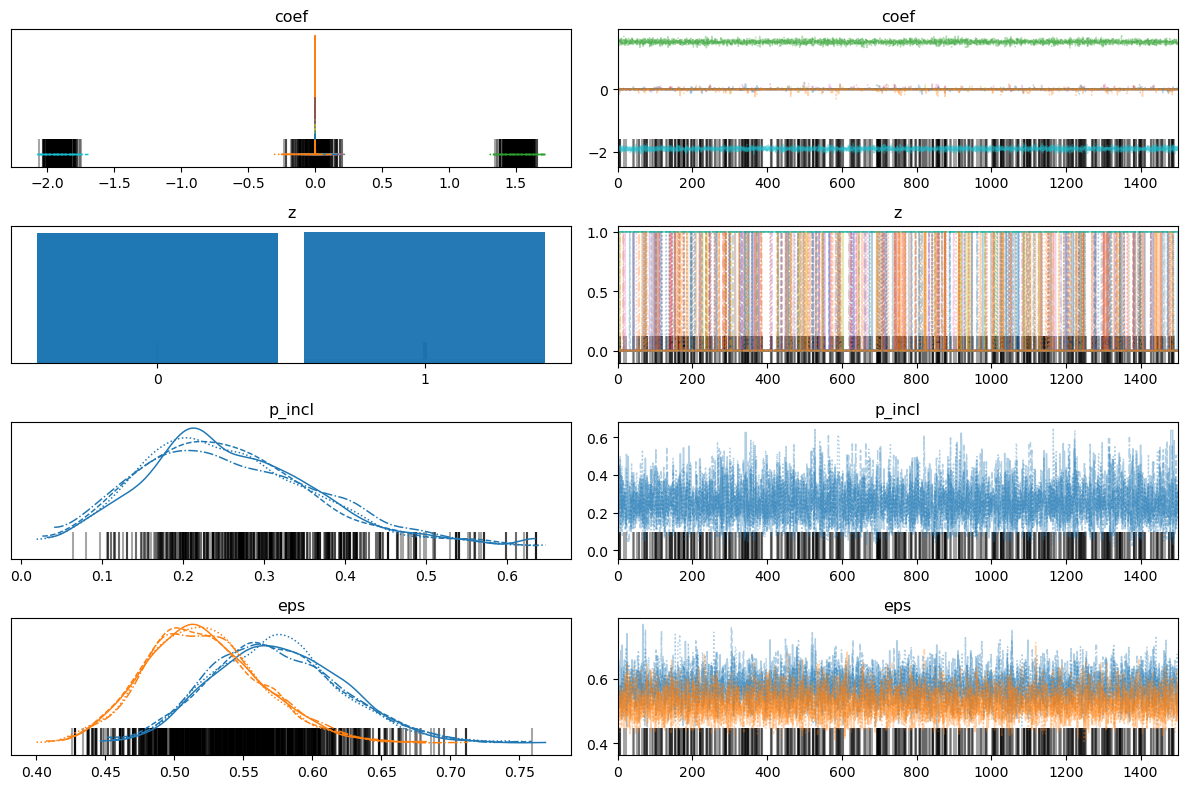

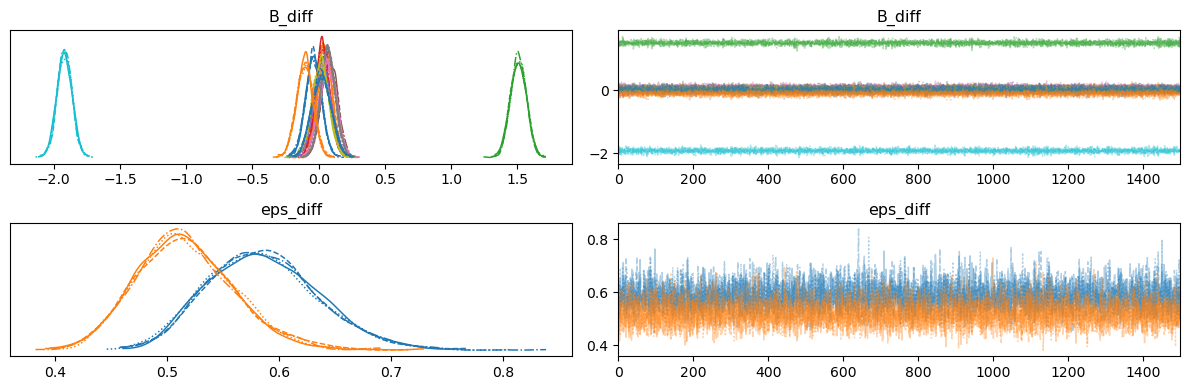

In [4]:
#Q2
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# 1. Generate synthetic data (multivariate regression with 2 outputs)
np.random.seed(101)
n = 80   # number of observations
p = 6    # number of predictors
m = 2    # number of outputs

# Design matrix (n x p)
X_data = np.random.randn(n, p)

# True coefficient matrix (p x m), most are zero
true_B = np.zeros((p, m))
true_B[1, 0] = 1.5   # nonzero coefficient for predictor 2 on output 1
true_B[4, 1] = -2.0  # nonzero coefficient for predictor 5 on output 2

# Generate Y_data = X_data @ true_B + noise
noise_scale = 0.5
Y_data = X_data @ true_B + np.random.randn(n, m) * noise_scale

# 2. Spike-and-Slab model for variable selection
with pm.Model() as model_spike_slab:
    # Inclusion probability for each coefficient
    p_incl = pm.Beta("p_incl", alpha=2, beta=2)
    
    # Binary indicator matrix z (p x m)
    z = pm.Bernoulli("z", p=p_incl, shape=(p, m))
    
    # Slab distribution for included coefficients
    coef_slab = pm.Normal("coef_slab", mu=0.0, sigma=3.0, shape=(p, m))
    
    # Final coefficients = z * slab
    coef = pm.Deterministic("coef", z * coef_slab)
    
    # Noise standard deviations (one per output)
    eps = pm.HalfNormal("eps", sigma=1.0, shape=m)
    
    # Linear predictor (n x m)
    mu = pm.math.dot(X_data, coef)
    
    # Observed Y: each column treated as Normal with its own eps
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=eps, observed=Y_data)
    
    # Sample using MCMC
    trace_spike_slab = pm.sample(1500, tune=500, target_accept=0.9, random_seed=101)

# 3. Diffuse Normal model (minimal L2 regularization)
with pm.Model() as model_diffuse:
    # Weakly informative Normal prior on all coefficients
    B_diff = pm.Normal("B_diff", mu=0, sigma=100, shape=(p, m))
    
    # Noise standard deviations (one per output)
    eps_diff = pm.HalfNormal("eps_diff", sigma=1.0, shape=m)
    
    mu_diff = pm.math.dot(X_data, B_diff)
    Y_obs_diff = pm.Normal("Y_obs_diff", mu=mu_diff, sigma=eps_diff, observed=Y_data)
    
    trace_diffuse = pm.sample(1500, tune=500, target_accept=0.9, random_seed=101)

# 4. Compare results: trace plots for spike-and-slab vs. diffuse priors
az.plot_trace(trace_spike_slab, var_names=["coef", "z", "p_incl", "eps"], compact=True)
plt.tight_layout()
plt.show()

az.plot_trace(trace_diffuse, var_names=["B_diff", "eps_diff"], compact=True)
plt.tight_layout()
plt.show()


Sequential sampling (2 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [indicator]
>NUTS: [coef_slab, sigma_ss]
Sampling 2 chains for 600 tune and 1_200 draw iterations (1_200 + 2_400 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, lam, beta_hs, sigma_hs]
Sampling 2 chains for 600 tune and 1_200 draw iterations (1_200 + 2_400 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


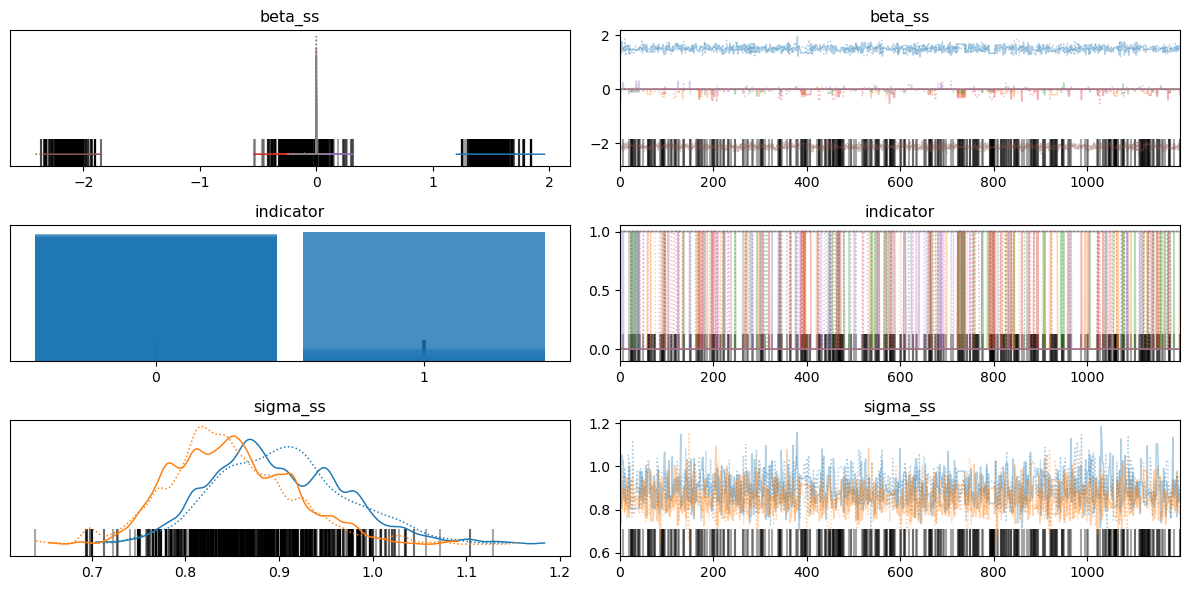

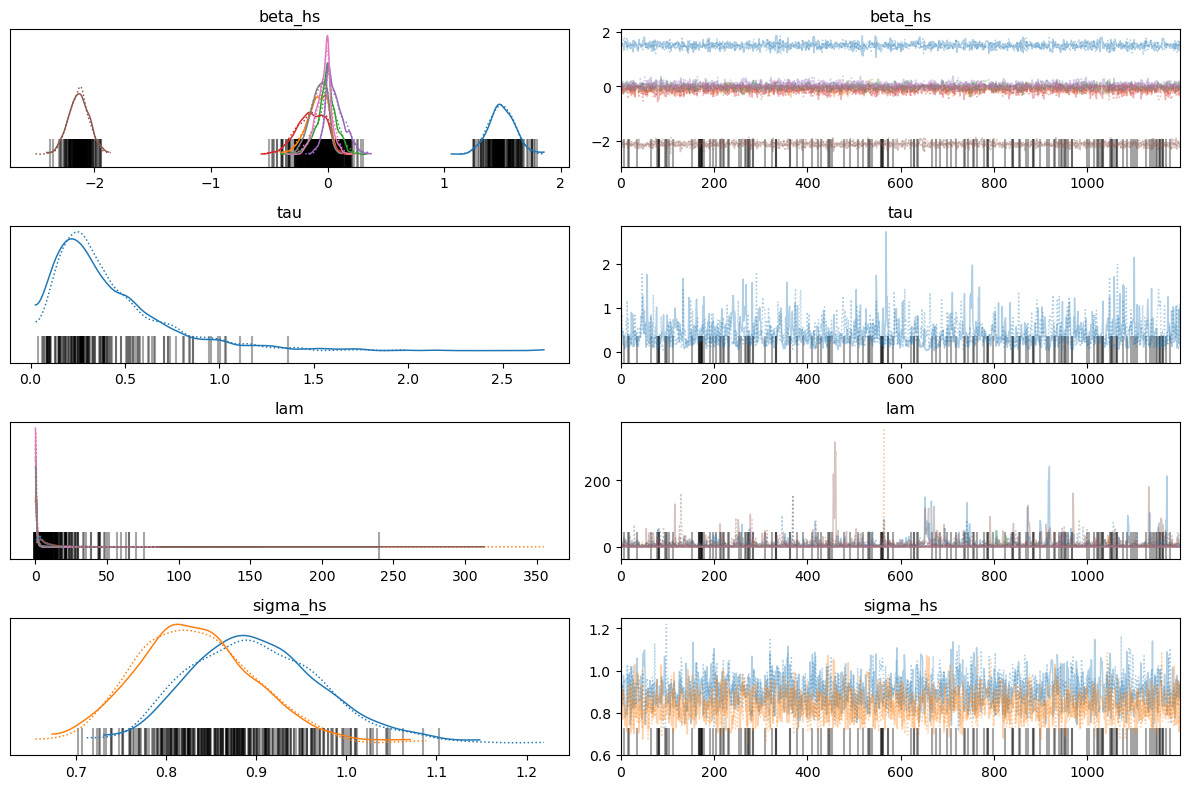

In [6]:
#Q3
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# =============================================================================
# 1. Generate Synthetic Data for Multivariate Regression
# =============================================================================
np.random.seed(2024)
n_obs = 80      # number of observations
n_features = 4  # number of predictors
n_out = 2       # number of output variables

# Design matrix (n_obs x n_features)
X = np.random.randn(n_obs, n_features)

# True coefficients (n_features x n_out), sparse: only a few nonzero entries
true_coef = np.zeros((n_features, n_out))
true_coef[0, 0] =  1.5    # Predictor 1 influences output 1
true_coef[2, 1] = -2.0    # Predictor 3 influences output 2

# Generate responses: Y = X * true_coef + noise
noise_level = 0.8
Y = X @ true_coef + np.random.normal(0, noise_level, (n_obs, n_out))

# =============================================================================
# 2. Spike-and-Slab Model for Variable Selection
#    - Introduces binary indicators to switch coefficients on/off.
# =============================================================================
with pm.Model() as spike_slab_model:
    # Binary indicators: shape (n_features x n_out)
    indicator = pm.Bernoulli("indicator", p=0.5, shape=(n_features, n_out))
    
    # Slab component: diffuse normal prior for coefficients if selected
    coef_slab = pm.Normal("coef_slab", mu=0.0, sigma=5.0, shape=(n_features, n_out))
    
    # Final coefficients: if indicator==0, coefficient is forced to 0
    beta_ss = pm.Deterministic("beta_ss", indicator * coef_slab)
    
    # Noise standard deviations, one for each output variable
    sigma_ss = pm.HalfNormal("sigma_ss", sigma=1.0, shape=n_out)
    
    # Linear predictor: matrix product of X and beta_ss (n_obs x n_out)
    mu_ss = pm.math.dot(X, beta_ss)
    
    # Likelihood: multivariate outputs assumed independent given mu and sigma
    Y_obs_ss = pm.Normal("Y_obs_ss", mu=mu_ss, sigma=sigma_ss, observed=Y)
    
    # Sample from the posterior
    trace_ss = pm.sample(1200, tune=600, cores=1, random_seed=2024, progressbar=False)

# =============================================================================
# 3. Horseshoe Prior Model for Sparsity
#    - Uses global and local shrinkage parameters to encourage sparsity.
# =============================================================================
with pm.Model() as horseshoe_model:
    # Global shrinkage parameter (controls overall sparsity)
    tau = pm.HalfCauchy("tau", beta=1.0)
    
    # Local shrinkage parameters: one for each coefficient
    lam = pm.HalfCauchy("lam", beta=1.0, shape=(n_features, n_out))
    
    # Coefficients with Horseshoe prior: Normal with standard deviation tau * lam
    beta_hs = pm.Normal("beta_hs", mu=0.0, sigma=tau * lam, shape=(n_features, n_out))
    
    # Noise standard deviations for each output
    sigma_hs = pm.HalfNormal("sigma_hs", sigma=1.0, shape=n_out)
    
    # Linear predictor: X dot beta_hs
    mu_hs = pm.math.dot(X, beta_hs)
    
    # Likelihood for the observed data
    Y_obs_hs = pm.Normal("Y_obs_hs", mu=mu_hs, sigma=sigma_hs, observed=Y)
    
    # Sample from the horseshoe model
    trace_hs = pm.sample(1200, tune=600, cores=1, random_seed=2024, progressbar=False)

# =============================================================================
# 4. Compare Results: Trace Plots for Both Models
# =============================================================================
# Plot for Spike-and-Slab model
az.plot_trace(trace_ss, var_names=["beta_ss", "indicator", "sigma_ss"], compact=True)
plt.tight_layout()
plt.show()

# Plot for Horseshoe model
az.plot_trace(trace_hs, var_names=["beta_hs", "tau", "lam", "sigma_hs"], compact=True)
plt.tight_layout()
plt.show()


This code generates synthetic data for a multivariate regression problem with sparse true coefficients. Two variable selection methods are implemented and compared: a Spike-and-Slab model, where binary indicators determine whether each coefficient is active, and a Horseshoe prior model, which uses global and local shrinkage parameters to promote sparsity. Bayesian inference is performed using PyMC, and the posterior distributions are visualized with ArviZ to assess how well each method recovers the true nonzero coefficients.

